# Tabula Rasa

---

---

### Overview

This notebook trains a mixed monotonic model, with sub-models to generate arbitrary quantile predictions and estimate epistemic uncertainty, using `TabulaRasaRegressor()`.

It's designed to work with Pandas DataFrame's and takes advantage of class types and feature names to cut down on code.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabularasa.TabulaRasa import TabulaRasaRegressor

---

### Load example data

If you haven't already, please generate the example dataset using the [example_data](example_data.ipynb) notebook.

In [2]:
df = pd.read_pickle('./data/simple_train.pkl')

Let's convert `x3` to a `category` data type so that we can generate embeddings for it (`TabulaRasaRegressor()` automatically handles this for all columns with `object` or `category` data types).

In [3]:
df['x3'] = df['x3'].astype('category')

---

### Initialize  and train

When initializing the model, we typically pass 3 arguments:
- `df`: A `pandas.DataFrame` containing the training data, or a sample of it.  No training happens on initialization, just categorizing features, setting up categorical feature mappings, and scalers for numeric features.  Therefore, if it is a sample of the full dataset, it should well represent your full dataset (in terms of having unique values for each categorical feature, and distributions for continuous features).
- `targets`: A `list` of column names to use as regressand(s) which are in `df`.  All other 'number', 'category', or 'object' columns in `df` are assumed to be features and will be included in the models. 
- `monotonic_constraints`: A `dict` where keys are features (column names on `df`) to take on monotonic relationships with the `targets` and values are 1 or -1 to signify the direction of that relationship: increasing or decreasing (respectively).
- `TabulaRasaRegressor()` also accepts named arguments, which are passed to the methods that define the three models behind the scenes.  Review the source code for `TabulaRasaRegressor()._define_model()` for more detail.  Here, we only specify `lr=0.005`.

In [4]:
model = TabulaRasaRegressor(df,
                            targets=['y'],
                            monotonic_constraints={'x1': 1, 'x2': 1},
                            lr=0.003)

Now, when we run `.fit()`, we'll train 3 models:
- The first generates standard predictions.
- The second can be used to estimate epistemic uncertainty.
- The third can generate predictions for arbitrary quantiles.

Note, we break pure adherence to the scikit API and simply pass the dataset which includes both the feature and target columns we'd like to train on into `.fit()`.

In [5]:
model.fit(df)

*** Training expectation model ***
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        6.1374        1.1617  1.6695
      2        1.0143        1.2034  1.5967
      3        0.9798        1.1648  1.5825
      4        0.9749        1.1681  1.6011
      5        0.9699        1.1578  1.5391
      6        0.9679        1.1604  1.5985
      7        0.9741        1.1530  1.5586
      8        0.9582        1.1489  1.6028
      9        0.9424        1.1214  1.7016
     10        0.8996        0.9862  1.5502
     11        0.6850        0.7007  1.5618
     12        0.4341        0.5146  1.5478
     13        0.2561        0.4866  1.5815
     14        0.2398        0.2409  1.6139
     15        0.2094        0.2928  1.7594
     16        0.1716        0.4393  1.6020
     17        0.1656        0.4558  1.5140
     18        0.1614        0.3881  1.5695
     19        0.1601        0.3343  1.6014
     20        0.1604        0.2588  1.53

     50        0.0122        0.0120  0.0491
     51        0.0121        0.0119  0.0421
     52        0.0121        0.0119  0.0475
     53        0.0121        0.0118  0.0406
     54        0.0120        0.0118  0.0462
     55        0.0120        0.0118  0.0403
     56        0.0119        0.0117  0.0410
     57        0.0119        0.0117  0.0414
     58        0.0118        0.0116  0.0466
     59        0.0118        0.0116  0.0439
     60        0.0118        0.0116  0.0454
     61        0.0117        0.0116  0.0457
     62        0.0117        0.0115  0.0409
     63        0.0117        0.0115  0.0434
     64        0.0116        0.0114  0.0469
     65        0.0116        0.0114  0.0417
     66        0.0116        0.0114  0.0457
     67        0.0115        0.0113  0.0431
     68        0.0115        0.0113  0.0451
     69        0.0115        0.0113  0.0420
     70        0.0114        0.0112  0.0461
     71        0.0114        0.0112  0.0461
     72        0.0114        0.0

    189        0.0096        0.0095  0.0492
    190        0.0096        0.0095  0.0435
    191        0.0096        0.0095  0.0429
    192        0.0096        0.0095  0.0473
    193        0.0096        0.0095  0.0489
    194        0.0096        0.0095  0.0447
    195        0.0096        0.0095  0.0405
    196        0.0095        0.0095  0.0440
    197        0.0096        0.0095  0.0491
    198        0.0095        0.0095  0.0419
    199        0.0095        0.0094  0.0421
    200        0.0095        0.0095  0.0482
    201        0.0095        0.0095  0.0431
    202        0.0095        0.0094  0.0430
    203        0.0095        0.0095  0.0416
    204        0.0095        0.0094  0.0422
    205        0.0095        0.0094  0.0432
    206        0.0095        0.0094  0.0504
    207        0.0095        0.0094  0.0431
    208        0.0095        0.0094  0.0439
    209        0.0095        0.0094  0.0450
    210        0.0095        0.0094  0.0447
    211        0.0095        0.0

We'll create a partial dependence plot to visualize how the monotonic network constrained our relationship between `x1` and `y`.

In [6]:
quantiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

Note, the `.predict()` method for `TabulaRasaRegressor()` accepts a data frame as well.  This data frame must include all training features, but does not need to include target column(s).

In [7]:
results = []
for q in np.quantile(df['x1'], quantiles):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = model.predict(dfc)
    p = pd.DataFrame(pd.Series(p[:, 0]).describe(percentiles=quantiles)).T
    p['x1'] = q
    results.append(p)
results = pd.concat(results, axis=0)

We can see below that, unlike with the simple MLP network, we have a monotonically increasing relationship between `x1` and `y`.

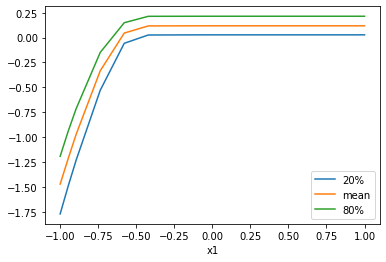

In [8]:
results.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

---

### Epistemic uncertainty

`TabulaRasaRegressor()` automatically trains and Orthornormal certificates model, and includes a method `.estimate_uncertainty()`, which accepts a data frame that must include all training features, but does not need to contain target column(s).

In [9]:
uncertainties = []
for q in np.linspace(-1.5, 1.5, 101):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = model.estimate_uncertainty(dfc)
    p = pd.DataFrame(pd.Series(p).describe(percentiles=quantiles)).T
    p['x1'] = q
    uncertainties.append(p)
uncertainties = pd.concat(uncertainties, axis=0)

And we can see from the plot below that uncertainties rise above 1 when projecting outside of the bounds we trained.  There is a bump in the middle, but it does not exceed 1 or align perfectly with the gap in our training data from 0 to 0.5.  Instead we see higher uncertainty when the function shows  high degree of curvature.

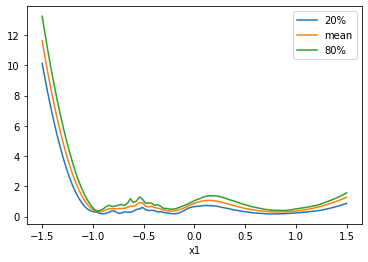

In [10]:
uncertainties.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

---

### Aleatoric uncertainty

`TabulaRasaRegressor()` also automatically trains a simultaneous quantile regression model.  Let's see how to use that.

Since each distinct value of `x3` contains all values of `x1`, let's examine prediction intervals by `x1` for a single value of `x3`.

In [11]:
df_slice = df[df['x3'] == 1].copy()

The `.predict_quantile()` takes in an extra argument `q` to specify which quantile should be predicted (defaults to 0.5, the 50th percentile).

In [12]:
p05 = model.predict_quantile(df_slice, q=0.05)
p = model.predict(df_slice)
p50 = model.predict_quantile(df_slice, q=0.5)
p95 = model.predict_quantile(df_slice, q=0.95)

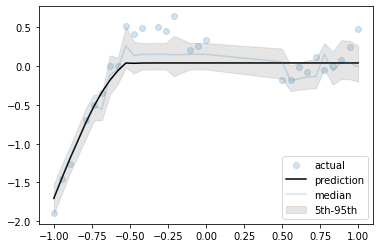

In [13]:
plt.scatter(df_slice['x1'], df_slice['y'], alpha=0.2, label='actual')
plt.plot(df_slice['x1'], p.flatten(), color='black', label='prediction')
plt.plot(df_slice['x1'], p50.flatten(), alpha=0.2, label='median')
plt.fill_between(df_slice['x1'], p05.flatten(), p95.flatten(), color='gray', alpha=0.2, label='5th-95th')
plt.legend()
plt.show()

We can see the 5th and 95th percentile prediction bounds capture the variation of most points around the median and base prediction model estimate, and can be used to approximate the aleatoric uncertainty in our model.